# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот ноутбук является шаблоном (Baseline) к текущему соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **Baseline** создается больше как шаблон, где можно посмотреть, как происходит обращение с входящими данными и что нужно получить на выходе. При этом ML начинка может быть достаточно простой. Это помогает быстрее приступить к самому ML, а не тратить ценное время на инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если наше решение хуже baseline -  мы явно делаем что-то не так и стоит попробовать другой путь) 

## В baseline мы сделаем следующее:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [1]:
!pip install -q tensorflow==2.3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.18.0 requires tensorflow-io-gcs-filesystem==0.18.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
beatrix-jupyterlab 3.1.1 requires google-cloud-bigquery-storage, which is not installed.
tfx-bsl 1.3.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.14.0 which is incompatible.
tfx-bsl 1.3.0 requires pyarrow<3,>=1, but you have pyarrow 5.0.0 which is incompatible.
tfx-bsl 1.3.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,<3,>=1.15.2, but you have tensorflow 2.3.0 which is incompatible.
tensorflow-transform 1.3.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.14.0 which is incompatible.
tensorflow-transform 1.3.0 requires pyarrow<3,>=1, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.3.0 requ

In [2]:
#аугментации изображений
!pip install albumentations -q

In [3]:
!pip install pymorphy2
!pip install pymorphy2-dicts

     |████████████████████████████████| 55 kB 278 kB/s 
     |████████████████████████████████| 8.2 MB 1.6 MB/s 
     |████████████████████████████████| 7.1 MB 909 kB/s 


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re
import pymorphy2

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import seaborn as sns
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2021-11-25 09:25:03.216238: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:
2021-11-25 09:25:03.216370: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.10 | packaged by conda-forge | (default, Sep 13 2021, 19:43:44) 
Numpy        : 1.19.5
Tensorflow   : 2.3.0


In [6]:
# Функция определения MAPE
def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Функция определения возраста владельца
def owners_age(string):
    age = 0
    if type(string) == str:
        strings = string.split(' ')
        if len(strings) > 3:
            if "лет" in strings[1]  or "год" in strings[1]:
                age = age + int(strings[0])
            else:
                age = age + int(strings[0]) / 10
            if "месяцев" in strings[4] or "месяц" in strings[4]:
                age = age + int(strings[3]) / 10
        else:
            if "лет" in strings[1]  or "год" in strings[1]:
                age = age + int(strings[0])
            if "месяцев" in strings[1] or "месяц" in strings[1]:
                age = age + int(strings[0]) / 10
    else:
        return -1
    return age

# Функция определения количества владельцев
def owners_count(string):
    if type(string) == str:
        return int(string[0])
    return -1

# Функция определения объема двигателя
def engine_capasity(string):
    if string == 'undefined LTR':
        string = '1.3 LTR'
    return float(str(string).split()[0])*1000

In [7]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 21
np.random.seed(RANDOM_SEED)

In [8]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [9]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [11]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

In [12]:
train.sample(5)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
6241,седан,BMW,чёрный,"ПТС оригинал, 1 владелец , в ДТП не участвовал...",2.0 LTR,177 N12,дизель,147203,2007,5ER,...,729000.0,2009,1100148518,SEDAN AUTOMATIC 2.0,автоматическая,1 владелец,NaN,Оригинал,задний,Левый
5043,купе,AUDI,белый,"Мятина на Левом крыле, База показывает правое,...",4.2 LTR,354 N12,бензин,71000,2007,S5,...,1000000.0,2009,1097668106,COUPE AUTOMATIC 4.2,автоматическая,1 владелец,NaN,Оригинал,полный,Левый
2754,седан,AUDI,белый,"Продаю свой автомобиль,я собственник,владею 2 ...",3.0 LTR,300 N12,бензин,195000,2011,A6,...,799999.0,2011,1099682190,SEDAN ROBOT 3.0,роботизированная,3 или более,2 года,Оригинал,полный,Левый
5251,седан,MERCEDES,синий,АСЦ / ЧЕСТНО!\n«АвтоСпецЦентр» Химки – это шир...,1.6 LTR,150 N12,бензин,47000,2016,CLA_KLASSE,...,1199000.0,2017,1099599034,SEDAN ROBOT 1.6,роботизированная,1 владелец,NaN,Оригинал,передний,Левый
5550,седан,BMW,серый,"Машина еще пахнет новой, вся передняя часть, а...",2.0 LTR,150 N12,дизель,24000,2018,3ER,...,2300000.0,2019,1100028768,SEDAN AUTOMATIC 2.0,автоматическая,1 владелец,9 месяцев,Оригинал,задний,Левый


Посмотрим на данные

**bodyType**

<AxesSubplot:>

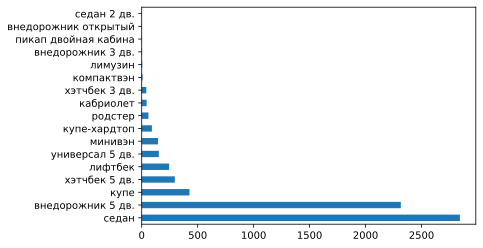

In [13]:
train['bodyType'].value_counts().plot.barh() 

**color**

<AxesSubplot:>

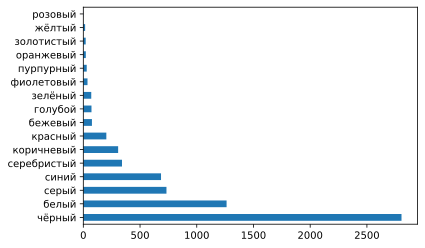

In [14]:
train['color'].value_counts().plot.barh()

**fuelType**

<AxesSubplot:>

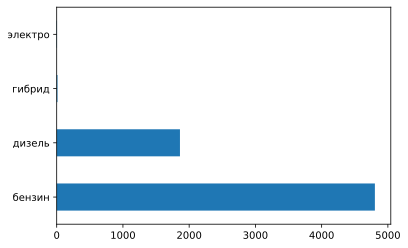

In [15]:
train['fuelType'].value_counts().plot.barh()

**engineDisplacement**

<AxesSubplot:>

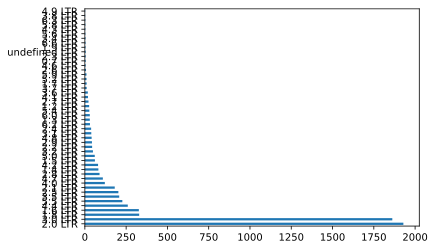

In [16]:
train['engineDisplacement'].value_counts().plot.barh()

**mileage**

<AxesSubplot:>

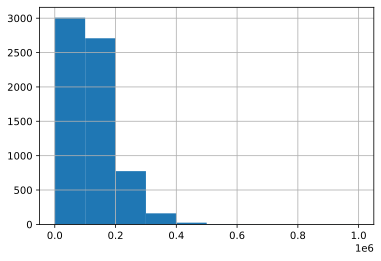

In [17]:
train['mileage'].hist()

**modelDate**

In [18]:
train['modelDate'].describe()

count    6682.000000
mean     2010.135588
std         5.370973
min      1975.000000
25%      2007.000000
50%      2011.000000
75%      2014.000000
max      2019.000000
Name: modelDate, dtype: float64

**productionDate**

In [19]:
train['productionDate'].describe()

count    6682.000000
mean     2012.031577
std         5.049676
min      1982.000000
25%      2009.000000
50%      2013.000000
75%      2016.000000
max      2020.000000
Name: productionDate, dtype: float64

**numberOfDoors**

<AxesSubplot:>

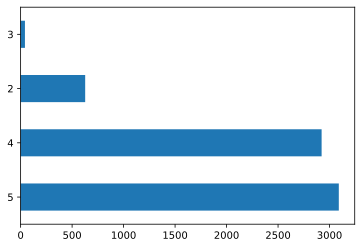

In [20]:
train['numberOfDoors'].value_counts().plot.barh()

**vehicleTransmission**

<AxesSubplot:>

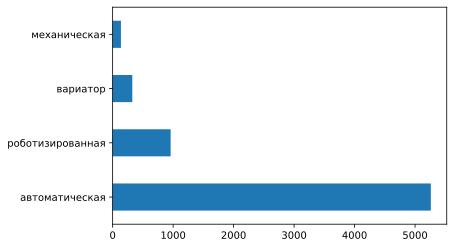

In [21]:
train['vehicleTransmission'].value_counts().plot.barh()

**Владельцы**

<AxesSubplot:>

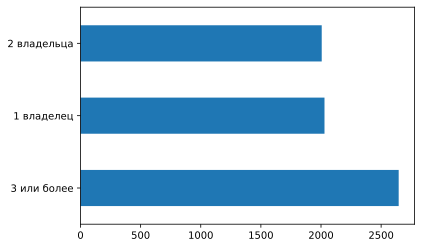

In [22]:
train['Владельцы'].value_counts().plot.barh()

**ПТС**

<AxesSubplot:>

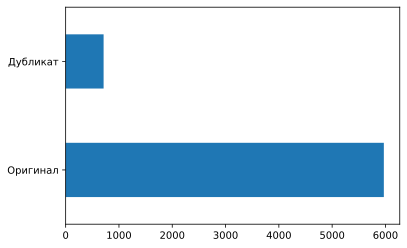

In [23]:
train['ПТС'].value_counts().plot.barh()

**Привод**

<AxesSubplot:>

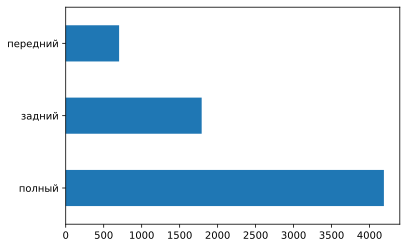

In [24]:
train['Привод'].value_counts().plot.barh()

**Price**

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


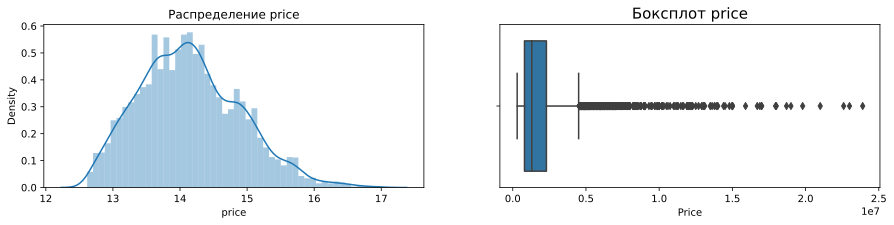

In [25]:
plt.figure(figsize=(15, 3))
plt.subplot(1,2,1)
plt.title(f"Распределение price")
sns.distplot(np.log(train['price']), bins=50)

plt.subplot(1,2,2)
sns.boxplot(train['price'])
plt.xlabel('Price')
plt.title(f"Боксплот price", fontsize=15)
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


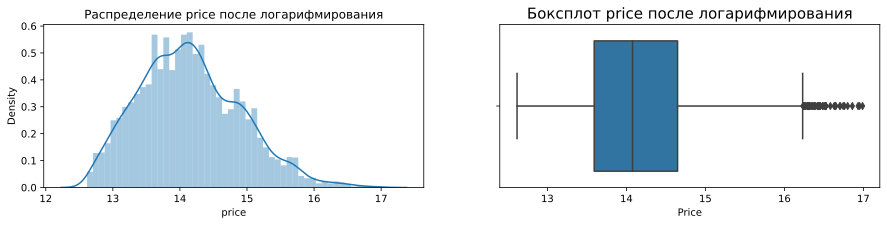

In [26]:
plt.figure(figsize=(15, 3))
plt.subplot(1,2,1)
plt.title(f"Распределение price после логарифмирования")
sns.distplot(np.log(train['price']), bins=50)

plt.subplot(1,2,2)
sns.boxplot(np.log(train['price']))
plt.xlabel('Price')
plt.title('Боксплот price после логарифмирования', fontsize=15)
plt.show()

Можно применить логарифмирование целевой переменной

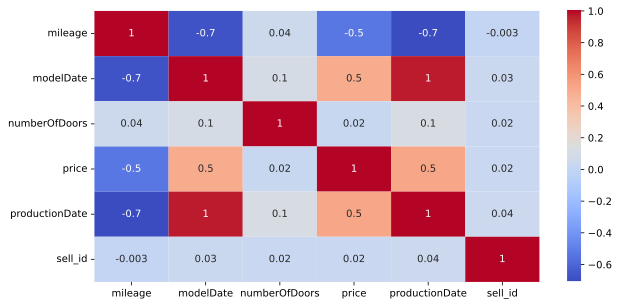

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.heatmap(train.corr(),fmt='.1g', annot=True, cmap='coolwarm')

Удалим 'productionDate'

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [28]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [29]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == {row[1]}"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(MAPE(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 20.52%


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

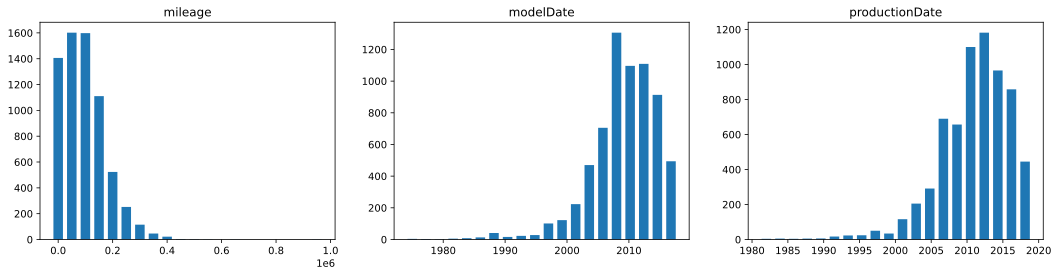

In [30]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
    columns = min(3, len(titles_values_dict))
    rows = (len(titles_values_dict) - 1) // columns + 1
    fig = plt.figure(figsize = (columns * 6, rows * 4))
    for i, (title, values) in enumerate(titles_values_dict.items()):
        hist, bins = np.histogram(values, bins = 20)
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
        ax.set_title(title)
    plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

# PreProc Tabular Data

In [31]:
#используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info',
                        'numberOfDoors', 'vehicleTransmission', 'Привод', 'ПТС', 'Руль', 'xDrive']

#используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate', 'engineDisplacement', 'enginePower',
                      'Владельцы', 'Владение', 'year_mileage']

In [32]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [33]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['description', 'sell_id',], axis = 1, inplace=True)
    
    
    # ################### Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    df_output['engineDisplacement'] = df_output['engineDisplacement'].apply(engine_capasity)
    df_output['enginePower'] = df_output['enginePower'].apply(lambda string: int(string.split(' ')[0]))
    df_output['modelDate'] = 2021 - df_output['modelDate']
    df_output.loc[df_output['model_info'] == '100', 'model_info'] = 'S4'
    df_output.loc[df_output['model_info'] == 'COUPE', 'model_info'] = 'S2'
    df_output.loc[df_output['model_info'] == 'None', 'model_info'] = 'C_KLASSE_AMG'
#     df_output['productionDate'] = 2021 - df_output['productionDate']
    df_output['Владельцы'] = df_output['Владельцы'].apply(lambda string: owners_count(string))
    df_output['Владение'] = df_output['Владение'].apply(lambda string: owners_age(string))
    df_output['ПТС'] = df_output['ПТС'].map({'Дубликат': 0, 'Оригинал': 1})
    df_output['Руль'] = df_output['Руль'].map({'Левый': 0, 'Правый': 1})
    df_output['year_mileage'] = df_output['mileage'] / (2021 - df_output['modelDate'])
    df_output['xDrive'] = df_output['name'].apply(lambda x: 1 if 'xDrive' in x else 0)
    df_output['bodyType'] = df_output['bodyType'].astype(str).apply(lambda x: None if x.strip() == '' else x)
    df_output['bodyType'] = df_output['bodyType'].apply(lambda x: x.split(' ')[0].lower())
    
    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
#     for column in numerical_features:
#         df_output[column].fillna(df_output[column].mean(), inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    # Нормализация данных
#     scaler = MinMaxScaler()
    scaler = RobustScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    df_output.drop(['vehicleConfiguration', 'productionDate', 'name'], axis = 1, inplace=True)
    
    return df_output

In [34]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,engineDisplacement,enginePower,mileage,modelDate,Владельцы,Владение,sample,price,year_mileage,bodyType_0,...,vehicleTransmission_3,Привод_0,Привод_1,Привод_2,ПТС_0,ПТС_1,Руль_0,Руль_1,xDrive_0,xDrive_1
5120,-1.4,-0.868852,-0.791780,-0.142857,-0.5,1.466667,1,1700000.0,-0.786958,0,...,1,0,1,0,0,1,1,0,1,0
5133,0.2,0.147541,-0.463232,-0.285714,0.5,0.000000,1,3575000.0,-0.460882,1,...,0,0,0,1,0,1,1,0,1,0
4335,0.7,-0.778689,-0.281756,3.000000,0.5,0.000000,1,1000000.0,-0.272196,1,...,0,0,0,1,0,1,1,0,1,0
2276,2.4,1.795082,0.339546,0.714286,0.0,0.000000,1,800000.0,0.340857,0,...,0,0,0,1,0,1,1,0,1,0
84,0.2,0.893443,-0.885402,-1.000000,-0.5,0.000000,0,0.0,-0.880363,1,...,0,0,0,1,0,1,1,0,1,0
1225,-0.8,-0.163934,0.501335,-0.285714,0.0,0.000000,0,0.0,0.496762,1,...,1,0,0,1,0,1,1,0,1,0
468,0.2,-0.163934,0.125893,-0.142857,0.0,0.000000,0,0.0,0.124581,1,...,0,0,0,1,0,1,1,0,1,0
5510,2.7,2.204918,-0.963334,1.857143,-0.5,6.000000,1,5000000.0,-0.956946,0,...,0,1,0,0,0,1,1,0,1,0
7711,-0.8,-0.008197,-0.298568,0.000000,0.0,1.300000,1,1500000.0,-0.296684,0,...,1,0,0,1,0,1,1,0,1,0
2546,-0.8,-0.385246,-0.096293,-0.857143,-0.5,1.300000,1,1950000.0,-0.098402,0,...,0,0,0,1,0,1,1,0,0,1


In [35]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 182 entries, engineDisplacement to xDrive_1
dtypes: float64(8), int64(1), uint8(173)
memory usage: 2.0 MB


## Split data

In [36]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [37]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 181 entries, engineDisplacement to xDrive_1
dtypes: float64(8), uint8(173)
memory usage: 399.8 KB


# Model 2: CatBoostRegressor

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [39]:
model = CatBoostRegressor(iterations=5000,
                          #depth=10,
                          #learning_rate = 0.5,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, np.log(y_train),
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

Learning rate set to 0.025058
0:	learn: 0.0419171	test: 0.0414202	best: 0.0414202 (0)	total: 51.8ms	remaining: 4m 18s
100:	learn: 0.0133266	test: 0.0140607	best: 0.0140607 (100)	total: 306ms	remaining: 14.9s
200:	learn: 0.0110270	test: 0.0119068	best: 0.0119068 (200)	total: 552ms	remaining: 13.2s
300:	learn: 0.0104536	test: 0.0114271	best: 0.0114271 (300)	total: 792ms	remaining: 12.4s
400:	learn: 0.0100712	test: 0.0111253	best: 0.0111253 (400)	total: 1.04s	remaining: 11.9s
500:	learn: 0.0096695	test: 0.0108100	best: 0.0108100 (500)	total: 1.28s	remaining: 11.5s
600:	learn: 0.0092863	test: 0.0105292	best: 0.0105290 (599)	total: 1.52s	remaining: 11.2s
700:	learn: 0.0090380	test: 0.0103797	best: 0.0103797 (700)	total: 1.76s	remaining: 10.8s
800:	learn: 0.0088024	test: 0.0102278	best: 0.0102278 (800)	total: 2.01s	remaining: 10.5s
900:	learn: 0.0085977	test: 0.0101068	best: 0.0101068 (900)	total: 2.25s	remaining: 10.3s
1000:	learn: 0.0084228	test: 0.0100071	best: 0.0100071 (1000)	total: 2.5

In [40]:
test_predict_catboost = np.exp(model.predict(X_test))
print(f"TEST mape: {(MAPE(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 12.79%


### Submission

In [41]:
sub_predict_catboost = np.exp(model.predict(X_sub))
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

Построим обычную сеть:

In [42]:
X_train.head(5)

,engineDisplacement,enginePower,mileage,modelDate,Владельцы,Владение,year_mileage,bodyType_0,bodyType_1,bodyType_2,...,vehicleTransmission_3,Привод_0,Привод_1,Привод_2,ПТС_0,ПТС_1,Руль_0,Руль_1,xDrive_0,xDrive_1
4560,0.2,-0.106557,1.572878,1.000000,0.5,0.633333,1.572192,0,0,0,...,0,0,0,1,0,1,1,0,1,0
4923,-1.0,-0.581967,0.274634,0.571429,0.0,0.933333,0.275542,0,0,0,...,0,0,1,0,0,1,1,0,1,0
2232,-0.8,-0.385246,-0.717595,-0.714286,0.0,0.666667,-0.713872,0,0,0,...,0,1,0,0,0,1,1,0,1,0
5920,-1.0,-0.385246,0.423005,0.000000,0.5,0.000000,0.420422,0,0,0,...,0,1,0,0,0,1,1,0,1,0
7895,-0.8,-0.049180,-0.393034,-0.142857,-0.5,2.366667,-0.390877,1,0,0,...,0,0,0,1,0,1,1,0,1,0


## Simple Dense NN

In [43]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="sigmoid"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dense(128, activation="relu"))
model.add(L.Dense(64, activation="relu"))
model.add(L.Dropout(0.25))
model.add(L.Dense(1, activation="linear"))

2021-11-25 09:25:57.287279: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:
2021-11-25 09:25:57.287376: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-25 09:25:57.287455: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (028c03c03f7b): /proc/driver/nvidia/version does not exist
2021-11-25 09:25:57.287820: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-25 09:25:57.296016: I tensorf

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               92672     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6

In [45]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [46]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [47]:
history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

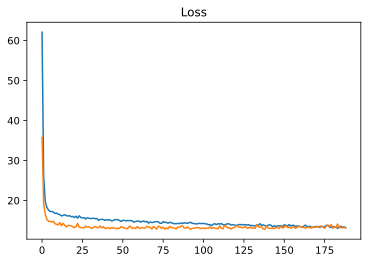

In [48]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [49]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [50]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(MAPE(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 13.09%


In [51]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

Рекомендации для улучшения Model 3:    
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'), поэтому эти данные можно удалить. Затем следует еще сильнее сократить размерность, например, выделив наличие xDrive в качестве отдельного признака.

# Model 4: NLP + Multiple Inputs

In [52]:
data['description']

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [53]:
data_NLP = data.copy()

Лемматизация занимает очень много времени. Для использования убрать комментарии

In [54]:
def lemmatization(text):
    text = " ".join(word.lower() for word in text.split()) #lowercasing and removing short words 
    text = re.sub('\-\s\r\n\s{1,}|\-\s\r\n|\r\n', '', text) #deleting newlines and line-breaks
    text = re.sub('[.,:;%©?*,!@#$%^&()\d]|[+=]|[[]|[]]|[/]|"|\s{2,}|-', ' ', text) #deleting symbols  
    text = " ".join(pymorphy2.MorphAnalyzer().parse(word)[0].normal_form for word in text.split())
    return text
# data_NLP['description'] = data_NLP['description'].apply(lemmatization)

In [55]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [56]:
# split данных
text_train = data['description'].iloc[X_train.index]
text_test = data['description'].iloc[X_test.index]
text_sub = data['description'].iloc[X_sub.index]

### Tokenizer

In [57]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
# Убрать комментарии, если используется лемматизация
# tokenize.fit_on_texts(data_NLP['description'])
tokenize.fit_on_texts(data['description'])

CPU times: user 1.82 s, sys: 0 ns, total: 1.82 s
Wall time: 1.82 s


In [58]:
tokenize.word_index

{'•': 1,
 'в': 2,
 'и': 3,
 'с': 4,
 'на': 5,
 'не': 6,
 'по': 7,
 'система': 8,
 'автомобиль': 9,
 'все': 10,
 'для': 11,
 'автомобиля': 12,
 'от': 13,
 'до': 14,
 'при': 15,
 'у': 16,
 'пробегом': 17,
 '2': 18,
 'состоянии': 19,
 'без': 20,
 'авто': 21,
 'салон': 22,
 'пакет': 23,
 'за': 24,
 'машина': 25,
 'автомобилей': 26,
 'сидений': 27,
 'птс': 28,
 'безопасности': 29,
 'то': 30,
 'bmw': 31,
 'из': 32,
 'более': 33,
 '000': 34,
 'автомобили': 35,
 'водителя': 36,
 'комплектация': 37,
 'есть': 38,
 '1': 39,
 'года': 40,
 'комплект': 41,
 'сиденья': 42,
 'только': 43,
 'дилера': 44,
 'салона': 45,
 'пробег': 46,
 'контроль': 47,
 'фары': 48,
 '6': 49,
 'диски': 50,
 'кредит': 51,
 'лет': 52,
 'передние': 53,
 '3': 54,
 'руля': 55,
 'датчик': 56,
 'пассажира': 57,
 'км': 58,
 'оригинал': 59,
 'подушки': 60,
 'а': 61,
 'мы': 62,
 '9': 63,
 'подогрев': 64,
 'заднего': 65,
 'состояние': 66,
 'вас': 67,
 '5': 68,
 'обслуживание': 69,
 'зеркал': 70,
 '–': 71,
 'торг': 72,
 'дтп': 73,
 '

In [59]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.73 s, sys: 0 ns, total: 1.73 s
Wall time: 1.73 s


In [60]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

Все косяки видны на фото, два комплекта резины, недавно поменяны масло фильтра, всё работает, причина продажи нужна машина побольше и проходимее. торг у капота по телефону не торгуюсь, машиной пользуюсь ежедневно, поэтому площадки и помощники в продаже мимо.
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     

### RNN NLP

In [61]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.Dense(128, activation="sigmoid"))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [62]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dense(128, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [63]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [64]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     10135552    seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

### Fit

In [65]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [66]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [67]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=64,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
89/89 [==============================] - 150s 2s/step - loss: 54.9728 - MAPE: 54.9728 - val_loss: 24.8436 - val_MAPE: 24.8436
Epoch 2/500
89/89 [==============================] - 152s 2s/step - loss: 22.9302 - MAPE: 22.9302 - val_loss: 17.4421 - val_MAPE: 17.4421
Epoch 3/500
89/89 [==============================] - 150s 2s/step - loss: 19.6452 - MAPE: 19.6452 - val_loss: 16.1636 - val_MAPE: 16.1636
Epoch 4/500
89/89 [==============================] - 152s 2s/step - loss: 18.0975 - MAPE: 18.0975 - val_loss: 15.4158 - val_MAPE: 15.4158
Epoch 5/500
89/89 [==============================] - 152s 2s/step - loss: 17.6928 - MAPE: 17.6928 - val_loss: 14.8717 - val_MAPE: 14.8717
Epoch 6/500
89/89 [==============================] - 161s 2s/step - loss: 16.7379 - MAPE: 16.7379 - val_loss: 14.4775 - val_MAPE: 14.4775
Epoch 7/500
89/89 [==============================] - 155s 2s/step - loss: 16.7099 - MAPE: 16.7099 - val_loss: 14.4156 - val_MAPE: 14.4156
Epoch 8/500
89/89 [===============

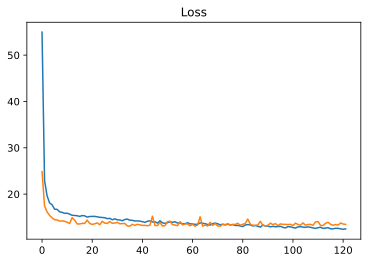

In [68]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [69]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [70]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(MAPE(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 13.46%


In [71]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста

# Model 5: Добавляем картинки

### Data

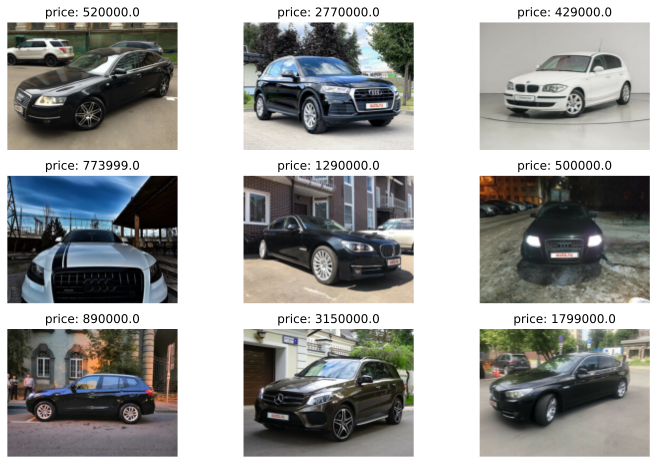

In [72]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [73]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

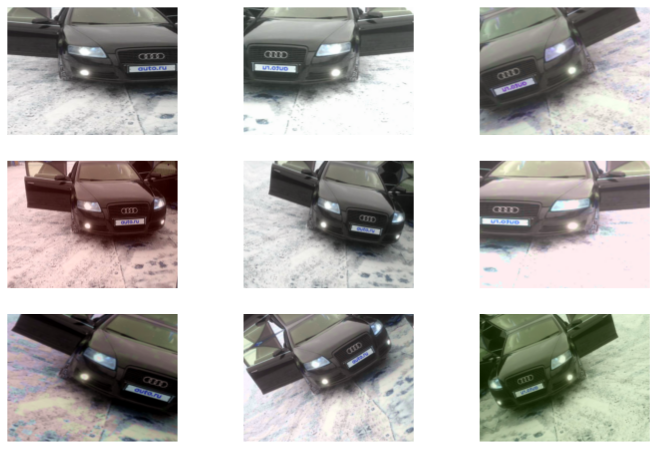

In [74]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4,
                          value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=224, width=200),
        albumentations.CenterCrop(height=200, width=224),
    ], p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.1, contrast_limit=0.1)
    ], p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(240, 320)
])

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [75]:
def make_augmentations(images):
    print('применение аугментаций', end = '')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end = '')
        augment_dict = augmentation(image = images[i])
        augmented_image = augment_dict['image']
        augmented_images[i] = augmented_image
    print('')
    return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [76]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [77]:
def process_image(image):
    return augmentation(image=image.numpy())['image']


def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen=MAX_SEQUENCE_LENGTH)


def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]


def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image, ] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text, ] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price


def tf_process_val_dataset_element(image, table_data, text, price):
    [text, ] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price


train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
)).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
)).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
)).map(tf_process_val_dataset_element)

# проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__()
test_dataset.__iter__().__next__()
sub_dataset.__iter__().__next__()

2021-11-25 14:46:05.749589: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 1308441600 exceeds 10% of free system memory.
2021-11-25 14:46:09.483694: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 1308441600 exceeds 10% of free system memory.


((<tf.Tensor: shape=(240, 320, 3), dtype=uint8, numpy=
  array([[[130, 123, 120],
          [128, 121, 118],
          [170, 163, 160],
          ...,
          [147, 152, 153],
          [219, 228, 231],
          [201, 212, 216]],
  
         [[186, 179, 176],
          [229, 222, 219],
          [210, 203, 200],
          ...,
          [152, 157, 158],
          [220, 229, 232],
          [200, 211, 215]],
  
         [[175, 168, 165],
          [224, 217, 214],
          [214, 207, 204],
          ...,
          [157, 162, 165],
          [221, 230, 233],
          [200, 211, 215]],
  
         ...,
  
         [[127, 118, 105],
          [118, 109,  96],
          [130, 121, 108],
          ...,
          [133, 121, 115],
          [145, 132, 124],
          [174, 162, 152]],
  
         [[124, 113,  99],
          [131, 119, 107],
          [123, 111,  99],
          ...,
          [156, 147, 138],
          [153, 143, 133],
          [163, 153, 143]],
  
         [[133, 122, 10

### Строим сверточную сеть для анализа изображений без "головы"

In [78]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights='imagenet',
                                                                       include_top=False,
                                                                       input_shape=(size[1], size[0], 3))
efficientnet_model.trainable = True
fine_tune_at = len(efficientnet_model.layers)//2
for layer in efficientnet_model.layers[:fine_tune_at]:
    layer.trainable =  False
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 2s 0us/step


In [79]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'sigmoid'),
    L.LayerNormalization(),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dense(128, activation = 'relu'),
    L.Dropout(0.25),
    ])

In [80]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LayerNormalization(),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.Dense(128, activation = 'sigmoid'),
    L.LSTM(64),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [81]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [82]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [83]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [84]:
# history = model.fit(train_dataset.batch(30),
#                     epochs=100,
#                     validation_data = test_dataset.batch(30),
#                     callbacks=callbacks_list
#                    )

In [85]:
# plt.title('Loss')
# plt.plot(history.history['MAPE'], label='train')
# plt.plot(history.history['val_MAPE'], label='test')
# plt.show();

In [86]:
# model.load_weights('../working/best_model.hdf5')
# model.save('../working/nn_final.hdf5')

In [87]:
# test_predict_nn3 = model.predict(test_dataset.batch(30))
# print(f"TEST mape: {(MAPE(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

In [88]:
# sub_predict_nn3 = model.predict(sub_dataset.batch(30))
# sample_submission['price'] = sub_predict_nn3[:,0]
# sample_submission.to_csv('nn3_submission.csv', index=False)

# Blend

In [89]:
# blend_predict = (test_predict_catboost + test_predict_nn1[:,0] + test_predict_nn3[:,0]) / 3
blend_predict = (test_predict_catboost + test_predict_nn1[:,0]) / 2
print(f"TEST mape: {(MAPE(y_test, blend_predict))*100:0.2f}%")

TEST mape: 12.39%


In [90]:
# blend_sub_predict = (sub_predict_catboost + sub_predict_nn1[:,0] + sub_predict_nn3[:,0]) / 3
blend_sub_predict = (sub_predict_catboost + sub_predict_nn1[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# Выводы:

В ходе выполнения проекта проведен анализ данных, их подготовка и обработка. Датасет очищен от шума и выбросов. Выполнена нормализация. Категориальные признаки обработаны с помощью get_dummies. Добавлены новые признаки. Часть признаков удалены на основании анализа корреляции. Для обработки текста использовались классические методы (токенизация). Дополнительно можно поработать над лемматизацией текста. Также в модель добавлена обработка изображений. Методом блендирования удалось еще больше улучшить результат модели. 

# Model Bonus: проброс признака

In [91]:
# # MLP
# model_mlp = Sequential()
# model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
# model_mlp.add(L.Dropout(0.5))
# model_mlp.add(L.Dense(256, activation="relu"))
# model_mlp.add(L.Dropout(0.5))

In [92]:
# # FEATURE Input
# # Iput
# productiondate = L.Input(shape=[1], name="productiondate")
# # Embeddings layers
# emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
# f_productiondate = L.Flatten()(emb_productiondate)

In [93]:
# combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# # being our regression head
# head = L.Dense(64, activation="relu")(combinedInput)
# head = L.Dense(1, activation="linear")(head)

# model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [94]:
# model.summary()

In [95]:
# optimizer = tf.keras.optimizers.Adam(0.01)
# model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [96]:
# history = model.fit([X_train, X_train.productionDate.values], y_train,
#                     batch_size=512,
#                     epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
#                     validation_data=([X_test, X_test.productionDate.values], y_test),
#                     callbacks=callbacks_list
#                    )

In [97]:
# model.load_weights('../working/best_model.hdf5')
# test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
# print(f"TEST mape: {(MAPE(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")